In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys
import warnings
from lib.merge import prepare_train_show

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning) 

In [2]:
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

spark = SparkSession \
    .builder \
    .appName("renovation") \
    .getOrCreate()

# set this parameter for date issue before 1582 (dpe database)
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [3]:
# import files
# File location and type
file_location_array = [
    {"location": "../training/pred_tremi_old.csv",
        "name": "pred_tremi_old", "delimiter": ","},
    {"location": "../training/pred_tremi.csv",
        "name": "pred_tremi_full", "delimiter": ","},
    {"location": "../training/dico.csv", "name": "dictionary", "delimiter": "\t"}
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type)
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )

In [4]:
# name the important datasets and cast to type
training_tremi_old = (
    dataframes['pred_tremi_old'].withColumns({
        'surface': F.col('surface').cast('int'),
        'heating_production': F.col('heating_production').cast('int'),
        'heating_emission': F.col('heating_emission').cast('int'),
    })
)
training_tremi = (
    dataframes['pred_tremi_full'].withColumns({
        'surface': F.col('surface').cast('int'),
        'heating_production': F.col('heating_production').cast('int'),
    })
)


dictionary = dataframes['dictionary']

In [5]:
training_surf_old = training_tremi_old.filter(F.col('surface').isNotNull()).drop('heating_emission', 'heating_production')

training_surf = training_tremi.filter(F.col('surface').isNotNull()).drop(
    'heating_production')

In [6]:
# librairies
import numpy as np
import matplotlib.pyplot as plt


# random forest
from sklearn.ensemble import RandomForestRegressor

# XGboost
from xgboost.sklearn import XGBRegressor

# HistGboost
from sklearn.ensemble import HistGradientBoostingClassifier

#hyperparams
from scipy.stats import uniform, randint
from sklearn.model_selection import cross_val_predict
from show import show_matrix, show_result
from sklearn.metrics import f1_score, accuracy_score, r2_score

0.25232991996782017 {'max_depth': 4, 'n_estimators': 138}
0.26708153626548603 {'learning_rate': 0.03478987566606426, 'max_depth': 2, 'n_estimators': 133}


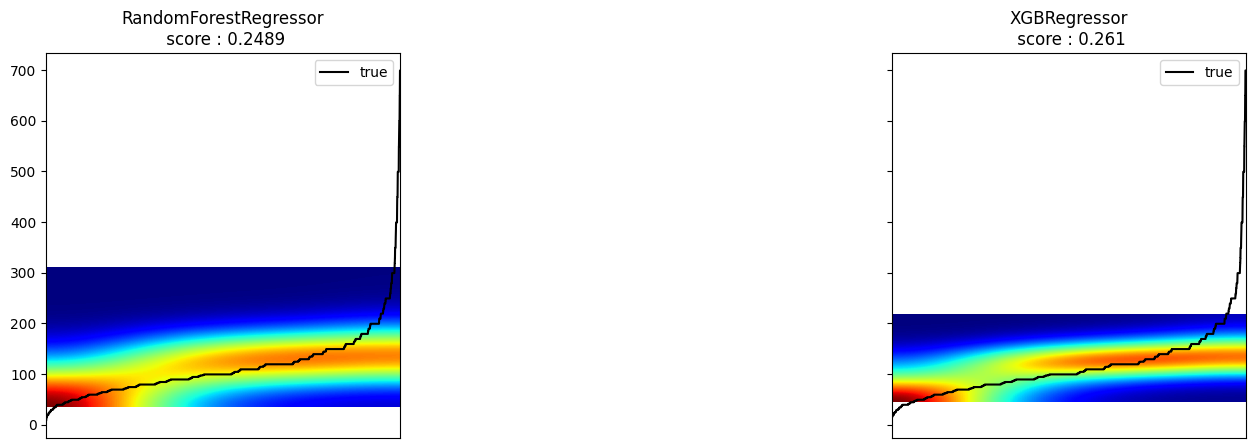

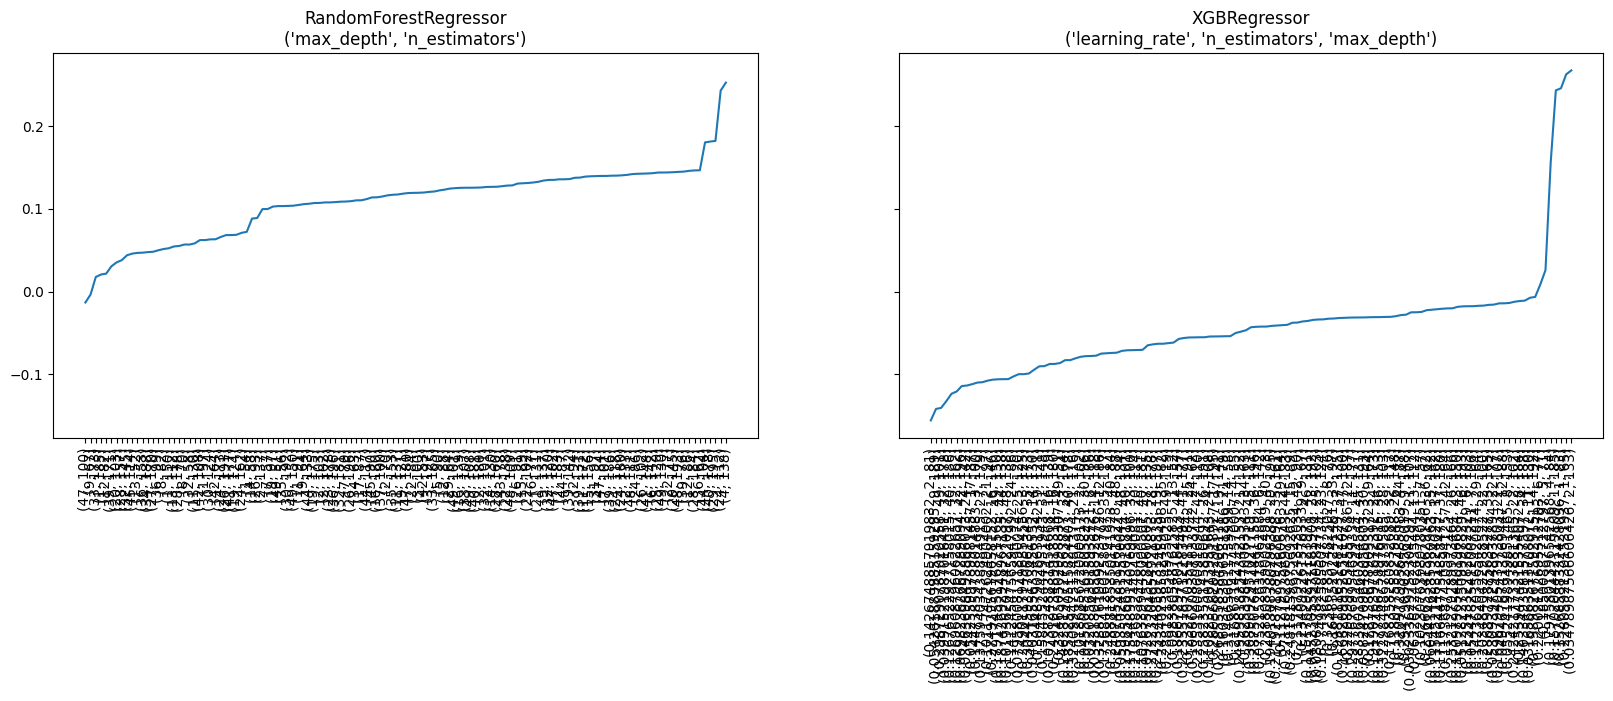

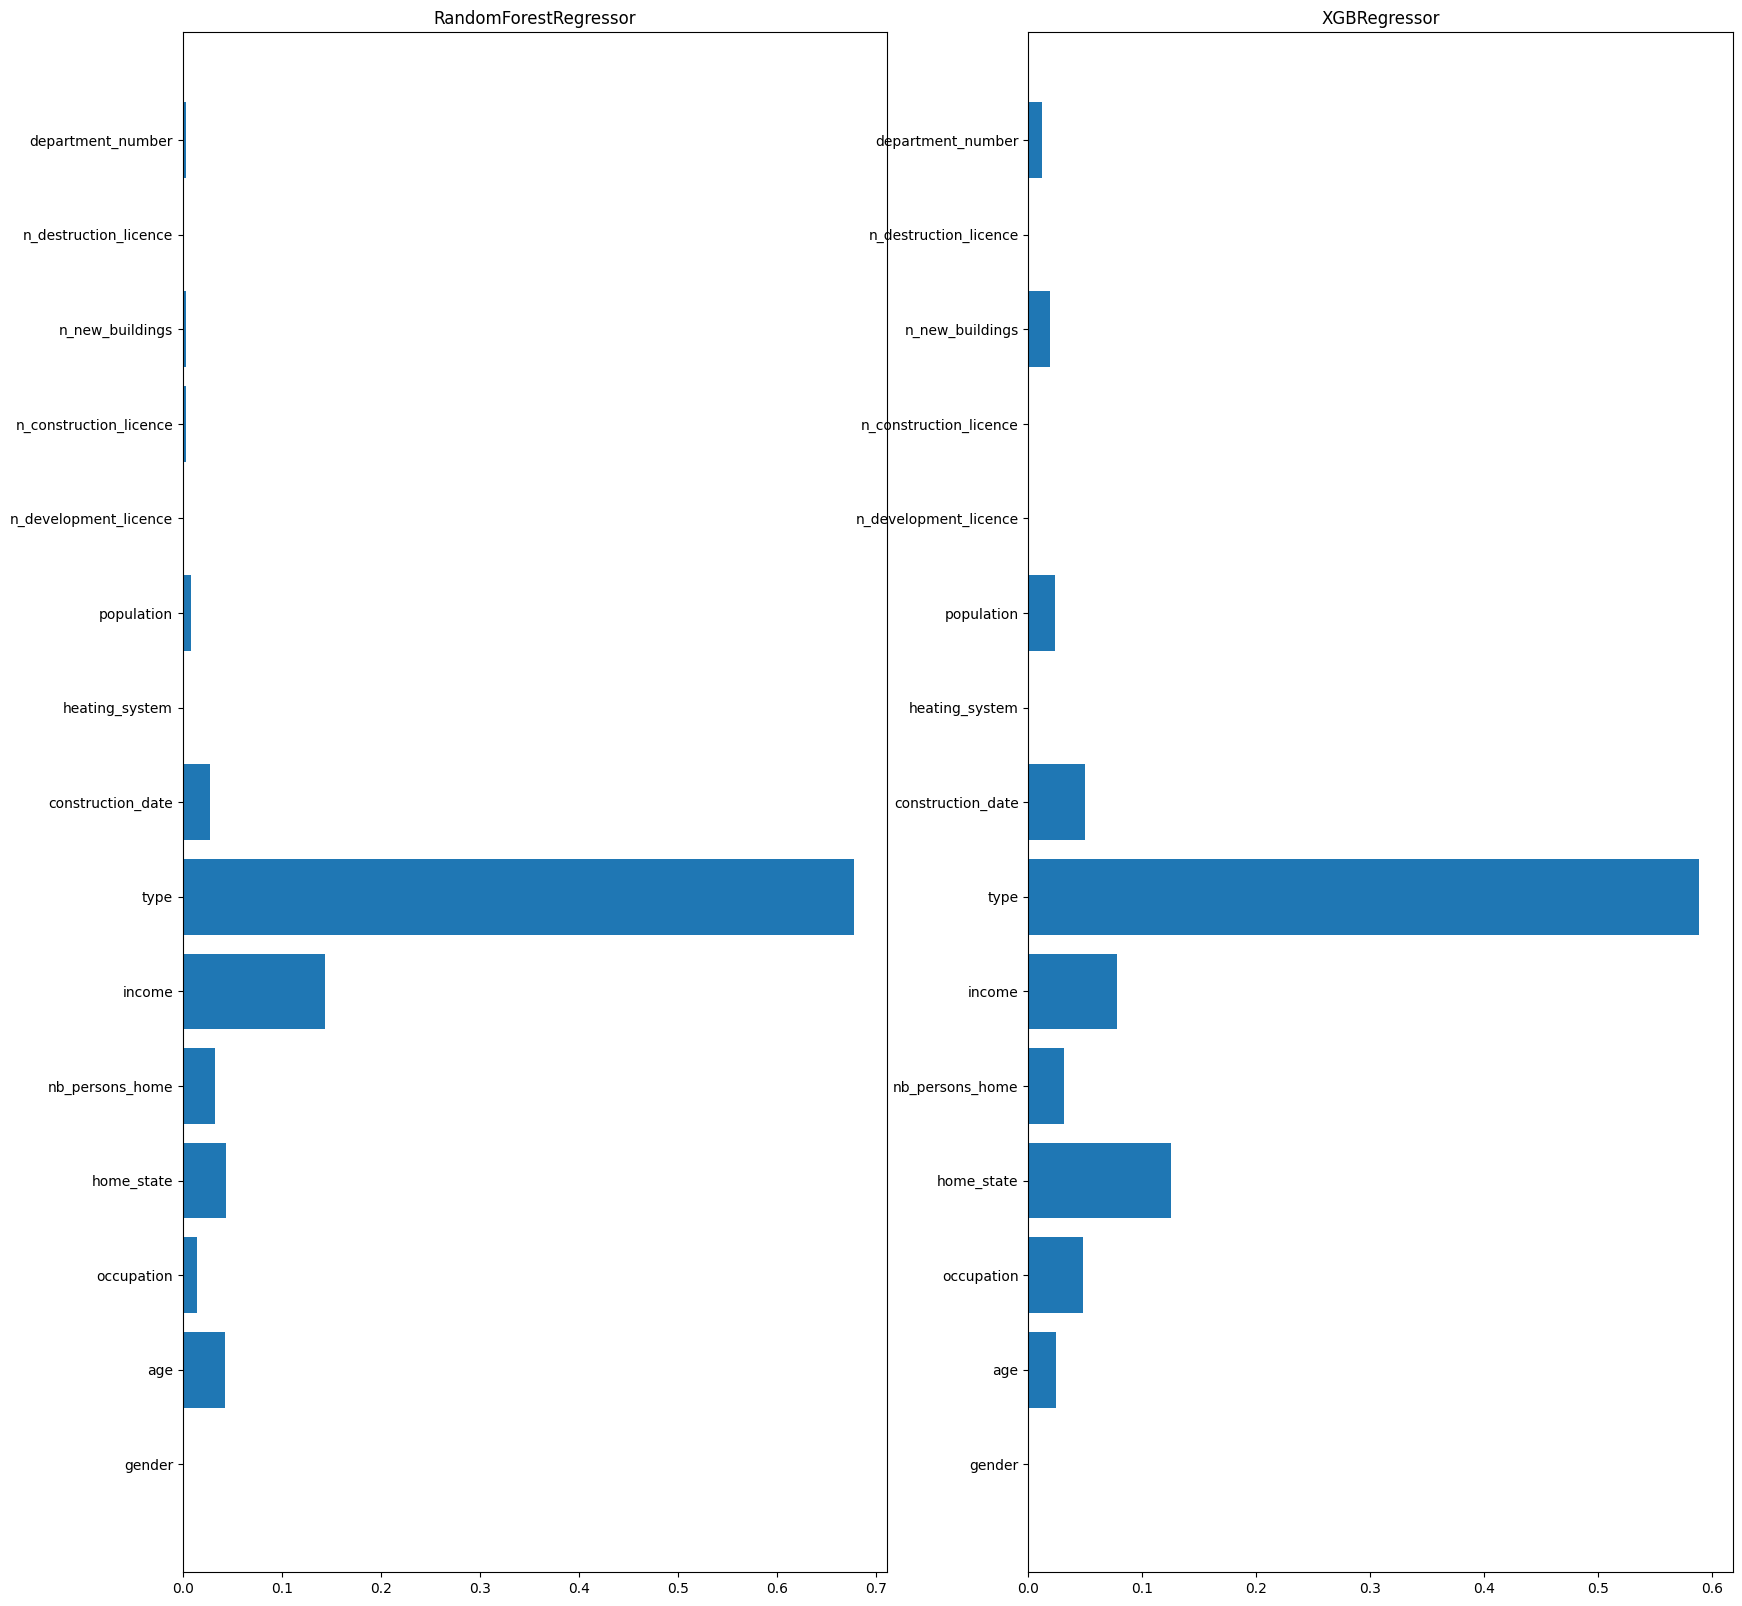

In [7]:
col_X_hot = [[], []]
col_y = ['surface']
col_X_not_hot = [[col[0] for col in training_surf_old.dtypes if col[0] not in col_X_hot[i] + col_y] for i in range(len(col_X_hot))]

categorical_features = [i for i in range(9)] + [14]

hyperparams_models = [
    {
        'max_depth' : randint(1,50),
        'n_estimators': randint(50,200),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    },
    {
        'learning_rate': uniform(0.03,0.3),
        'n_estimators' : randint(50,200),
        'max_depth' : randint(1,50),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    }
]
models = {
    'RandomForestRegressor' : RandomForestRegressor,
    'XGBRegressor' : XGBRegressor
}
best_models_surf = prepare_train_show(training_surf_old, dictionary, categorical_features, col_X_hot, col_X_not_hot, col_y,
                         False, True, hyperparams_models, models, random_state=42, test_size=0.4, verbose=0, scoring='r2')

In [8]:
training_surf_cat = training_surf_old.withColumn(
    'surface',
    F.when(F.col('surface') <= 70, 0)
    .when((F.col('surface') > 70) & (F.col('surface') <= 115), 1)
    .otherwise(2)
)

col_X_hot = []
col_y = ['surface']
col_X_not_hot = [col[0] for col in training_surf_old.dtypes if col[0] not in col_X_hot + col_y]

X_surf = training_surf_old.select(col_X_not_hot).toPandas().to_numpy()
y_surf_cat = training_surf_cat.select(col_y).toPandas().to_numpy().ravel()

    
if 0 not in np.unique(y_surf_cat):
    y_surf_cat = y_surf_cat - 1

y_surf_reg = training_surf_old.select(col_y).toPandas().to_numpy().ravel()

treshold = 100000
if X_surf.shape[0] > treshold:
    np.random.seed(42)
    indexes = np.random.choice(X_surf.shape[0], treshold, replace=False)
    X_surf = X_surf[indexes, :]
    y_surf_cat = y_surf_cat[indexes]
    y_surf_reg = y_surf_reg[indexes]


In [10]:
surf_regressor = best_models_surf[max(best_models_surf, key= lambda x: best_models_surf.get(x)[1])][0]
classifier_param = {'l2_regularization': 0.17592525267734538, 'learning_rate': 0.03542260908465626, 'max_iter': 241}

surf_classifier = HistGradientBoostingClassifier(**classifier_param)

y_pred_surf_regressor = cross_val_predict(surf_regressor, X_surf, y_surf_reg, cv=4)
y_pred_surf_classifier = cross_val_predict(surf_classifier, X_surf, y_surf_cat, cv=4)

In [11]:
y_pred_surf_regressor_to_cat = (
    spark.createDataFrame(y_pred_surf_regressor, ['surface'])
    .withColumn(
        'surface',
        F.when(F.col('surface') <= 70, 0)
        .when((F.col('surface') > 70) & (F.col('surface') <= 115), 1)
        .otherwise(2)
    )
    .toPandas()
    .to_numpy()
    .ravel()
)

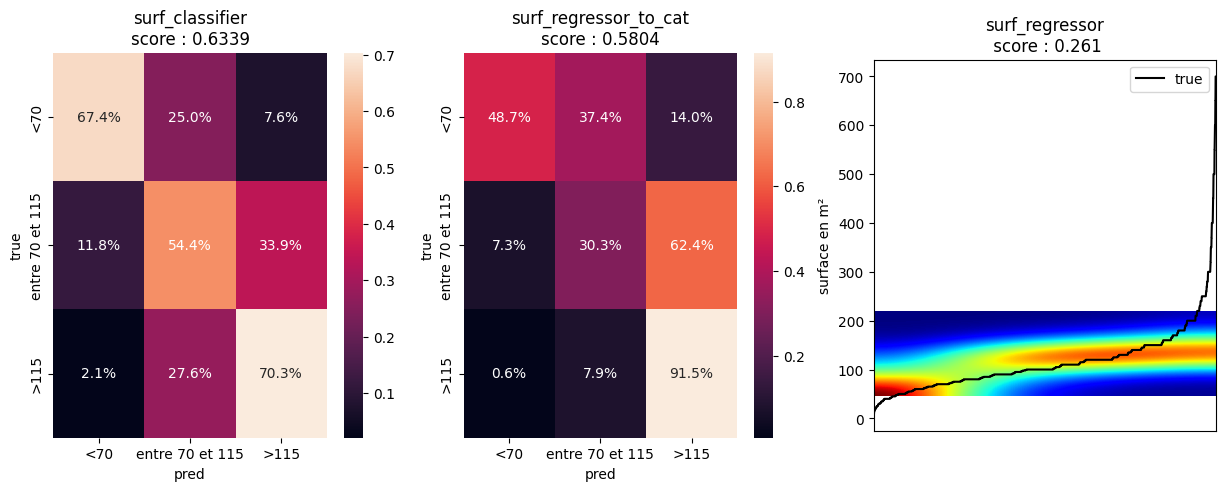

In [13]:
f, ax = plt.subplots(1,3, figsize=(15,5))
plt.subplots_adjust(hspace=0.35)
labels = ['<70', 'entre 70 et 115', '>115']

show_matrix(y_pred_surf_classifier, y_surf_cat, ax[0], f'surf_classifier', labels)
show_matrix(y_pred_surf_regressor_to_cat, y_surf_cat, ax[1], f'surf_regressor_to_cat', labels)
show_result(y_pred_surf_regressor, y_surf_reg, ax[2], f'surf_regressor')
ax[2].set_ylabel('surface en m²')
plt.show()